## Feature Importance and Feature Selection With XGBoost in Python

A benefit of using ensembles of decision tree methods like gradient boosting is that they can automatically provide estimates of feature importance from a trained predictive model.

In this post you will discover how you can estimate the importance of features for a predictive modeling problem using the XGBoost library in Python.

After reading this post you will know:

    How feature importance is calculated using the gradient boosting algorithm.
    How to plot feature importance in Python calculated by the XGBoost model.
    How to use feature importance calculated by XGBoost to perform feature selection.

## Feature Importance in Gradient Boosting

A benefit of using gradient boosting is that after the boosted trees are constructed, it is relatively straightforward to retrieve importance scores for each attribute.

Generally, importance provides a score that indicates how useful or valuable each feature was in the construction of the boosted decision trees within the model. The more an attribute is used to make key decisions with decision trees, the higher its relative importance.

This importance is calculated explicitly for each attribute in the dataset, allowing attributes to be ranked and compared to each other.

Importance is calculated for a single decision tree by the amount that each attribute split point improves the performance measure, weighted by the number of observations the node is responsible for. The performance measure may be the purity (Gini index) used to select the split points or another more specific error function.

The feature importances are then averaged across all of the the decision trees within the model.

## Manually Plot Feature Importance

A trained XGBoost model automatically calculates feature importance on your predictive modeling problem.

We can plot these scores on a bar chart directly to get a visual indication of the relative importance of each feature in the dataset.


[0.10621195 0.24240209 0.08803371 0.07818192 0.10381888 0.14867325
 0.10059208 0.13208608]


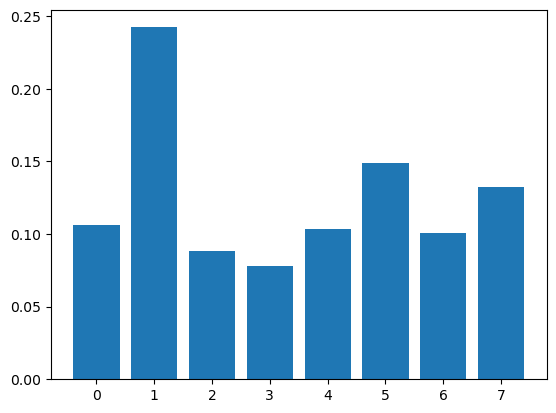

In [1]:
# plot feature importance manually

from numpy import loadtxt
from xgboost import XGBClassifier
from matplotlib import pyplot

# load data
dataset = loadtxt('/mnt/data1/my_codes/my_notebooks/boosting/data/pima-indians-diabetes.csv', delimiter=",")

# split data into X and y
X = dataset[:,0:8]
y = dataset[:,8]

# fit model no training data
model = XGBClassifier(importance_type='gain')
model.fit(X, y)

# feature importance
print(model.feature_importances_)

# plot
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()

When model trained with multi-class/multi-label/multi-target dataset, the feature importance is “averaged” over all targets. The “average” is defined based on the importance type.

Note: Your results may vary given the stochastic nature of the algorithm or evaluation procedure, or differences in numerical precision. Consider running the example a few times and compare the average outcome.

A downside of this plot is that the features are ordered by their input index rather than their importance. We could sort the features before plotting.

Thankfully, there is a built in plot function to help us.

## Using theBuilt-in XGBoost Feature Importance Plot

The XGBoost library provides a built-in function to plot features ordered by their importance.


How the importance is calculated: either “weight”, “gain”, or “cover”

    ”weight” is the number of times a feature appears in a tree

    ”gain” is the average gain of splits which use the feature

    ”cover” is the average coverage of splits which use the feature where coverage is defined as the number of samples affected by the split



The function is called plot_importance() and can be used as follows:

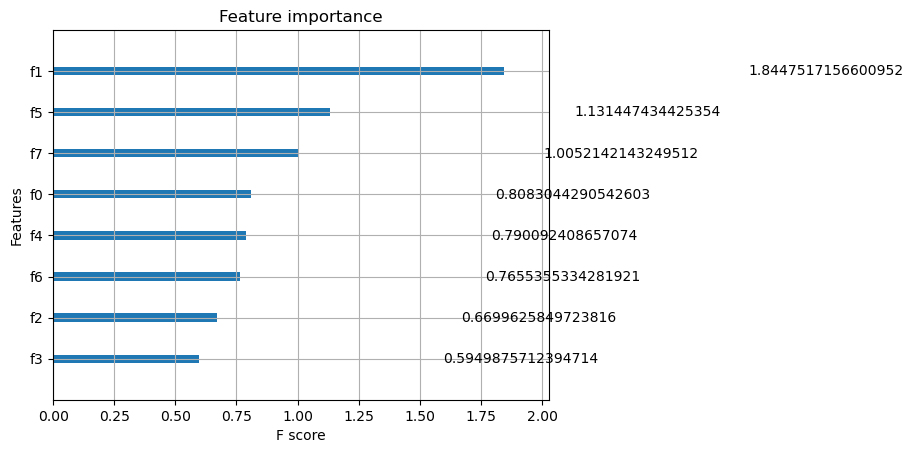

In [2]:

# plot feature importance using built-in function
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

# load data
dataset = loadtxt('/mnt/data1/my_codes/my_notebooks/boosting/data/pima-indians-diabetes.csv', delimiter=",")

# split data into X and y
X = dataset[:,0:8]
y = dataset[:,8]

# fit model no training data
model = XGBClassifier()
model.fit(X, y)

# plot feature importance
plot_importance(model, importance_type='gain')
pyplot.show()

## Feature Selection with XGBoost Feature Importance Scores

Feature importance scores can be used for feature selection in scikit-learn.

This is done using the SelectFromModel class that takes a model and can transform a dataset into a subset with selected features.

This class can take a pre-trained model, such as one trained on the entire training dataset. It can then use a threshold to decide which features to select. This threshold is used when you call the transform() method on the SelectFromModel instance to consistently select the same features on the training dataset and the test dataset.

In the example below we first train and then evaluate an XGBoost model on the entire training dataset and test datasets respectively.

Using the feature importances calculated from the training dataset, we then wrap the model in a SelectFromModel instance. We use this to select features on the training dataset, train a model from the selected subset of features, then evaluate the model on the testset, subject to the same feature selection scheme.

In [3]:
# use feature importance for feature selection
from numpy import loadtxt
from numpy import sort
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

# load data
dataset = loadtxt('/mnt/data1/my_codes/my_notebooks/boosting/data/pima-indians-diabetes.csv', delimiter=",")

# split data into X and y
X = dataset[:,0:8]
Y = dataset[:,8]

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

# fit model on all training data
model = XGBClassifier()
model.fit(X_train, y_train)

# make predictions for test data and evaluate
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# Fit model using each importance as a threshold

thresholds = sort(model.feature_importances_)
#thresholds = [0.05, 0.10, 0.15, 0.20]
print("THRESHOLDS:", thresholds)

for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)

    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)

    # eval model
    select_X_test = selection.transform(X_test)

    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Accuracy: 74.02%
THRESHOLDS: [0.08799458 0.08907107 0.09801763 0.09824964 0.09959181 0.13577053
 0.15170808 0.23959665]
Thresh=0.088, n=8, Accuracy: 74.02%
Thresh=0.089, n=7, Accuracy: 71.65%
Thresh=0.098, n=6, Accuracy: 71.26%
Thresh=0.098, n=5, Accuracy: 74.41%
Thresh=0.100, n=4, Accuracy: 74.80%
Thresh=0.136, n=3, Accuracy: 71.26%
Thresh=0.152, n=2, Accuracy: 71.26%
Thresh=0.240, n=1, Accuracy: 67.32%


We can see that the performance of the model generally decreases with the number of selected features.

On this problem there is a trade-off of features to test set accuracy and we could decide to take a less complex model (fewer attributes such as n=4) and accept a modest decrease in estimated accuracy from 77.95% down to 76.38%.

This is likely to be a wash on such a small dataset, but may be a more useful strategy on a larger dataset and using cross validation as the model evaluation scheme.